In [136]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"jeehyun","key":"9b55f71c7720ce4b258ba2fa90180bfd"}'}

In [137]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [138]:
!kaggle datasets download -d pierremegret/dialogue-lines-of-the-simpsons
!unzip dialogue-lines-of-the-simpsons.zip

dialogue-lines-of-the-simpsons.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  dialogue-lines-of-the-simpsons.zip
replace simpsons_dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: simpsons_dataset.csv    


In [139]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [140]:
df = pd.read_csv('simpsons_dataset.csv')
df.shape

(158314, 2)

In [141]:
df.isnull().sum()

raw_character_text    17814
spoken_words          26459
dtype: int64

In [142]:
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

raw_character_text    0
spoken_words          0
dtype: int64

In [143]:
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


###spacy: 텍스트 전처리에 유용한 라이브러리

<br/> 

<img src = "https://miro.medium.com/max/700/1*zSSERxP1F_Ge3LLFYN33Kw.png">


<img src = "https://miro.medium.com/max/700/1*2ZxttHTRunqS-yh9lUZbqA.png">

- Text: The original word text.
- Lemma: The base form of the word.
- POS: The simple part-of-speech tag.
- Tag: The detailed part-of-speech tag.
- Dep: Syntactic dependency, i.e. the relation between tokens.
- Shape: The word shape — capitalization, punctuation, digits.
- is alpha: Is the token an alpha character?
- is stop: Is the token part of a stop list, i.e. the most common words of the language?

In [144]:
nlp = spacy.load('en', disable = ['ner', 'parser'])

def cleaning(doc):
    txt = [token.lemma_ for token in doc if not token.is_stop]
    if len(txt) > 2:
        return ' '.join(txt)

custom pipeline을 만들고 이것을 spacy에 추가할 수도 있다.

In [145]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])

In [146]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.18 mins


In [147]:
df_clean = pd.DataFrame({'clean' : txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(85964, 1)

## models.phrases - Phrase

Automatically detect common phrases

to catch words like "mr_burns" or "bart_simpson"

In [ ]:
from gensim.models.phrases import Phrases, Phraser

sent = [row.split() for row in df_clean['clean']]
phrases = Phrases(sent, min_count = 30, progress_per = 10000)

INFO - 04:55:08: collecting all words and their counts
INFO - 04:55:08: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 04:55:08: PROGRESS: at sentence #10000, processed 63561 words and 52816 word types
INFO - 04:55:09: PROGRESS: at sentence #20000, processed 130943 words and 99866 word types
INFO - 04:55:09: PROGRESS: at sentence #30000, processed 192972 words and 138532 word types
INFO - 04:55:09: PROGRESS: at sentence #40000, processed 249842 words and 172659 word types
INFO - 04:55:09: PROGRESS: at sentence #50000, processed 311265 words and 208566 word types
INFO - 04:55:09: PROGRESS: at sentence #60000, processed 373588 words and 243702 word types
INFO - 04:55:09: PROGRESS: at sentence #70000, processed 436441 words and 278740 word types
INFO - 04:55:09: PROGRESS: at sentence #80000, processed 497829 words and 311886 word types
INFO - 04:55:09: collected 330804 word types from a corpus of 537160 words (unigram + bigrams) and 85964 sentences
INFO - 04:55:09: us

In [ ]:
sentences = phrases[sent]

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
# defaultdict: 주어진 객체의 기본값을 딕셔너리 값의 초깃값으로 지정 (숫자, 리스트, 셋 등으로 초기화)

word_freq = defaultdict(int)

for sent in sentences:
    for i in sent:
        word_freq[i] += 1

len(word_freq)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


30178

In [ ]:
sorted(word_freq, key = word_freq.get, reverse = True)[:10]

['oh', 'like', 'know', 'get', 'hey', 'think', 'right', 'look', 'want', 'come']

In [ ]:
import multiprocessing
from gensim.models import Word2Vec

In [ ]:
cores = multiprocessing.cpu_count() 

In [ ]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

- negative = int, If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. (5, 20)

In [ ]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 05:03:47: collecting all words and their counts
/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
INFO - 05:03:47: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 05:03:48: PROGRESS: at sentence #10000, processed 61718 words, keeping 9558 word types
INFO - 05:03:48: PROGRESS: at sentence #20000, processed 127351 words, keeping 14506 word types
INFO - 05:03:48: PROGRESS: at sentence #30000, processed 187829 words, keeping 17619 word types
INFO - 05:03:49: PROGRESS: at sentence #40000, processed 243332 words, keeping 20385 word types
INFO - 05:03:49: PROGRESS: at sentence #50000, processed 303182 words, keeping 22878 word types
INFO - 05:03:49: PROGRESS: at sentence #60000, processed 363940 words, keeping 25200 word types
INFO - 05:03:50: PROGRESS: at sentence #7

Time to build vocab: 0.06 mins


In [ ]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 05:04:06: training model with 1 workers on 3319 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
INFO - 05:04:07: EPOCH 1 - PROGRESS: at 23.75% examples, 47037 words/s, in_qsize 0, out_qsize 0
INFO - 05:04:08: EPOCH 1 - PROGRESS: at 51.79% examples, 48551 words/s, in_qsize 0, out_qsize 0
INFO - 05:04:09: EPOCH 1 - PROGRESS: at 76.60% examples, 48658 words/s, in_qsize 0, out_qsize 0
INFO - 05:04:10: worker thread finished; awaiting finish of 0 more threads
INFO - 05:04:10: EPOCH - 1 : training on 523700 raw words (198820 effective words) took 4.1s, 48928 effective words/s
INFO - 05:04:11: EPOCH 2 - PROGRESS: at 23.75% examples, 47875 words/s, in_qsize 0, out_qsize 0
INFO - 05:04:12: EPOCH 2 - PROGRESS: at 49

Time to train the model: 2.07 mins


In [ ]:
# init_sims: 필요없는 메모리를 unload 

w2v_model.init_sims(replace=True)

INFO - 05:07:27: precomputing L2-norms of word weight vectors


In [ ]:
w2v_model.wv.most_similar(positive=["homer"])

[('bongo', 0.7892625331878662),
 ('snuggle', 0.7671867609024048),
 ('marge', 0.7644451260566711),
 ('rude', 0.749160885810852),
 ('gee', 0.7487244606018066),
 ('wife', 0.7475229501724243),
 ('attract', 0.740212082862854),
 ('sorry', 0.7362596988677979),
 ('crummy', 0.7324546575546265),
 ('worry', 0.7276907563209534)]

In [ ]:
w2v_model.wv.most_similar(positive=["homer_simpson"])

[('congratulation', 0.7833476662635803),
 ('council', 0.776748776435852),
 ('governor', 0.7675871253013611),
 ('recent', 0.7505858540534973),
 ('pleased', 0.7456398010253906),
 ('easily', 0.7414093613624573),
 ('waylon', 0.739801287651062),
 ('committee', 0.7376796007156372),
 ('hutz', 0.7365367412567139),
 ('fellow', 0.7291965484619141)]

In [ ]:
w2v_model.wv.most_similar(positive=["marge"])

[('convince', 0.7828617095947266),
 ('rude', 0.7779331803321838),
 ('sorry', 0.7651908993721008),
 ('homer', 0.7644451260566711),
 ('brunch', 0.7626014351844788),
 ('loving', 0.7620963454246521),
 ('grownup', 0.7593902349472046),
 ('attract', 0.7561254501342773),
 ('darling', 0.7545438408851624),
 ('arrange', 0.7535865306854248)]

In [ ]:
w2v_model.wv.most_similar(positive=["bart"])

[('lisa', 0.8465646505355835),
 ('homework', 0.8011668920516968),
 ('mom', 0.7943856120109558),
 ('convince', 0.7812077403068542),
 ('surprised', 0.779674232006073),
 ('upset', 0.7675125002861023),
 ('substitute', 0.7666676044464111),
 ('strangle', 0.766088604927063),
 ('typical', 0.759172260761261),
 ('mom_dad', 0.7550473809242249)]

In [ ]:
w2v_model.wv.similarity('maggie', 'baby')

0.71941334

In [ ]:
w2v_model.wv.similarity('bart', 'nelson')

0.6334215

In [ ]:
w2v_model.wv.doesnt_match(['jimbo', 'milhouse', 'kearney'])

WARNING - 05:09:37: vectors for words {'kearney'} are not present in the model, ignoring these words
/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'jimbo'

In [ ]:
w2v_model.wv.doesnt_match(["nelson", "bart", "milhouse"])

/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'nelson'

In [ ]:
w2v_model.wv.doesnt_match(['homer', 'patty', 'selma'])

/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'homer'

In [ ]:
w2v_model.wv.most_similar(positive=["woman", "homer"], negative=["marge"], topn=3)

[('admire', 0.6986847519874573),
 ('obvious', 0.6464340686798096),
 ('carefully', 0.6315312385559082)]

In [ ]:
w2v_model.wv.most_similar(positive=["woman", "bart"], negative=["man"], topn=3)

[('lisa', 0.742364227771759),
 ('parent', 0.7420445084571838),
 ('pregnant', 0.729728102684021)]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 10 dimensions with PCA
    reduc = PCA(n_components=10).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

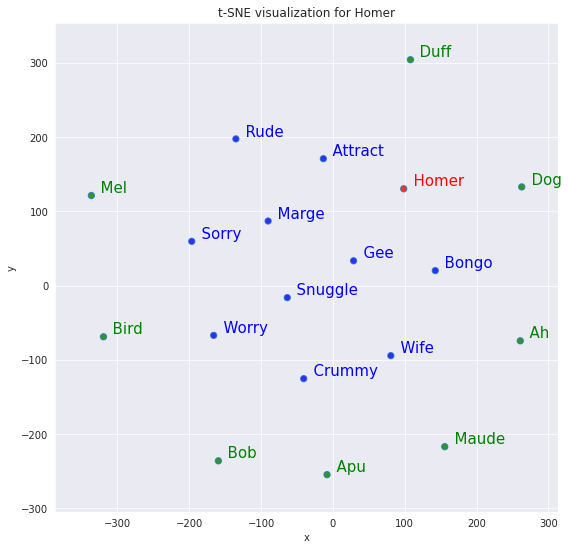

In [ ]:
tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])

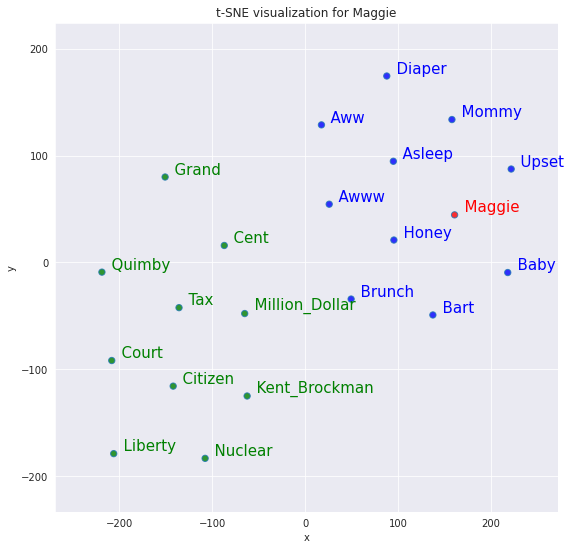

In [ ]:
tsnescatterplot(w2v_model, 'maggie', [i[0] for i in w2v_model.wv.most_similar(negative=["maggie"])])

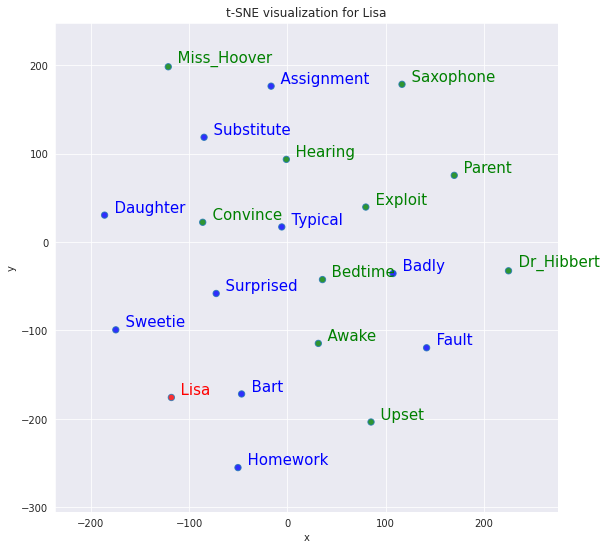

In [ ]:
tsnescatterplot(w2v_model, "lisa", [t[0] for t in w2v_model.wv.most_similar(positive=["lisa"], topn=20)][10:])

In [ ]:
vocab = list(w2v_model.wv.vocab)
X = w2v_model[vocab]

print(len(X))
print(X[0][:10])
tsne = TSNE(n_components=2)

# 100개의 단어에 대해서만 시각화
X_tsne = tsne.fit_transform(X[:100, :])

3319
[ 0.00294705  0.05643334 -0.00102312 -0.0915788  -0.0221776   0.11130938
  0.06014834  0.11598982 -0.03254361 -0.08424393]


In [ ]:
df = pd.DataFrame(X_tsne, index=vocab[:100], columns=['x', 'y'])
df.shape

(100, 2)

In [ ]:
df.head(10)

,x,y
actually,-1.603644,-1.327721
little,0.775807,-2.386968
disease,-2.571558,4.656646
magazine,-2.658721,3.807059
news,-4.565229,2.710232
show,-4.334090,2.675107
natural,-3.672944,4.742846
think,-0.977321,-1.976857
know,-1.203498,-1.821201
sure,-1.167156,-2.405091


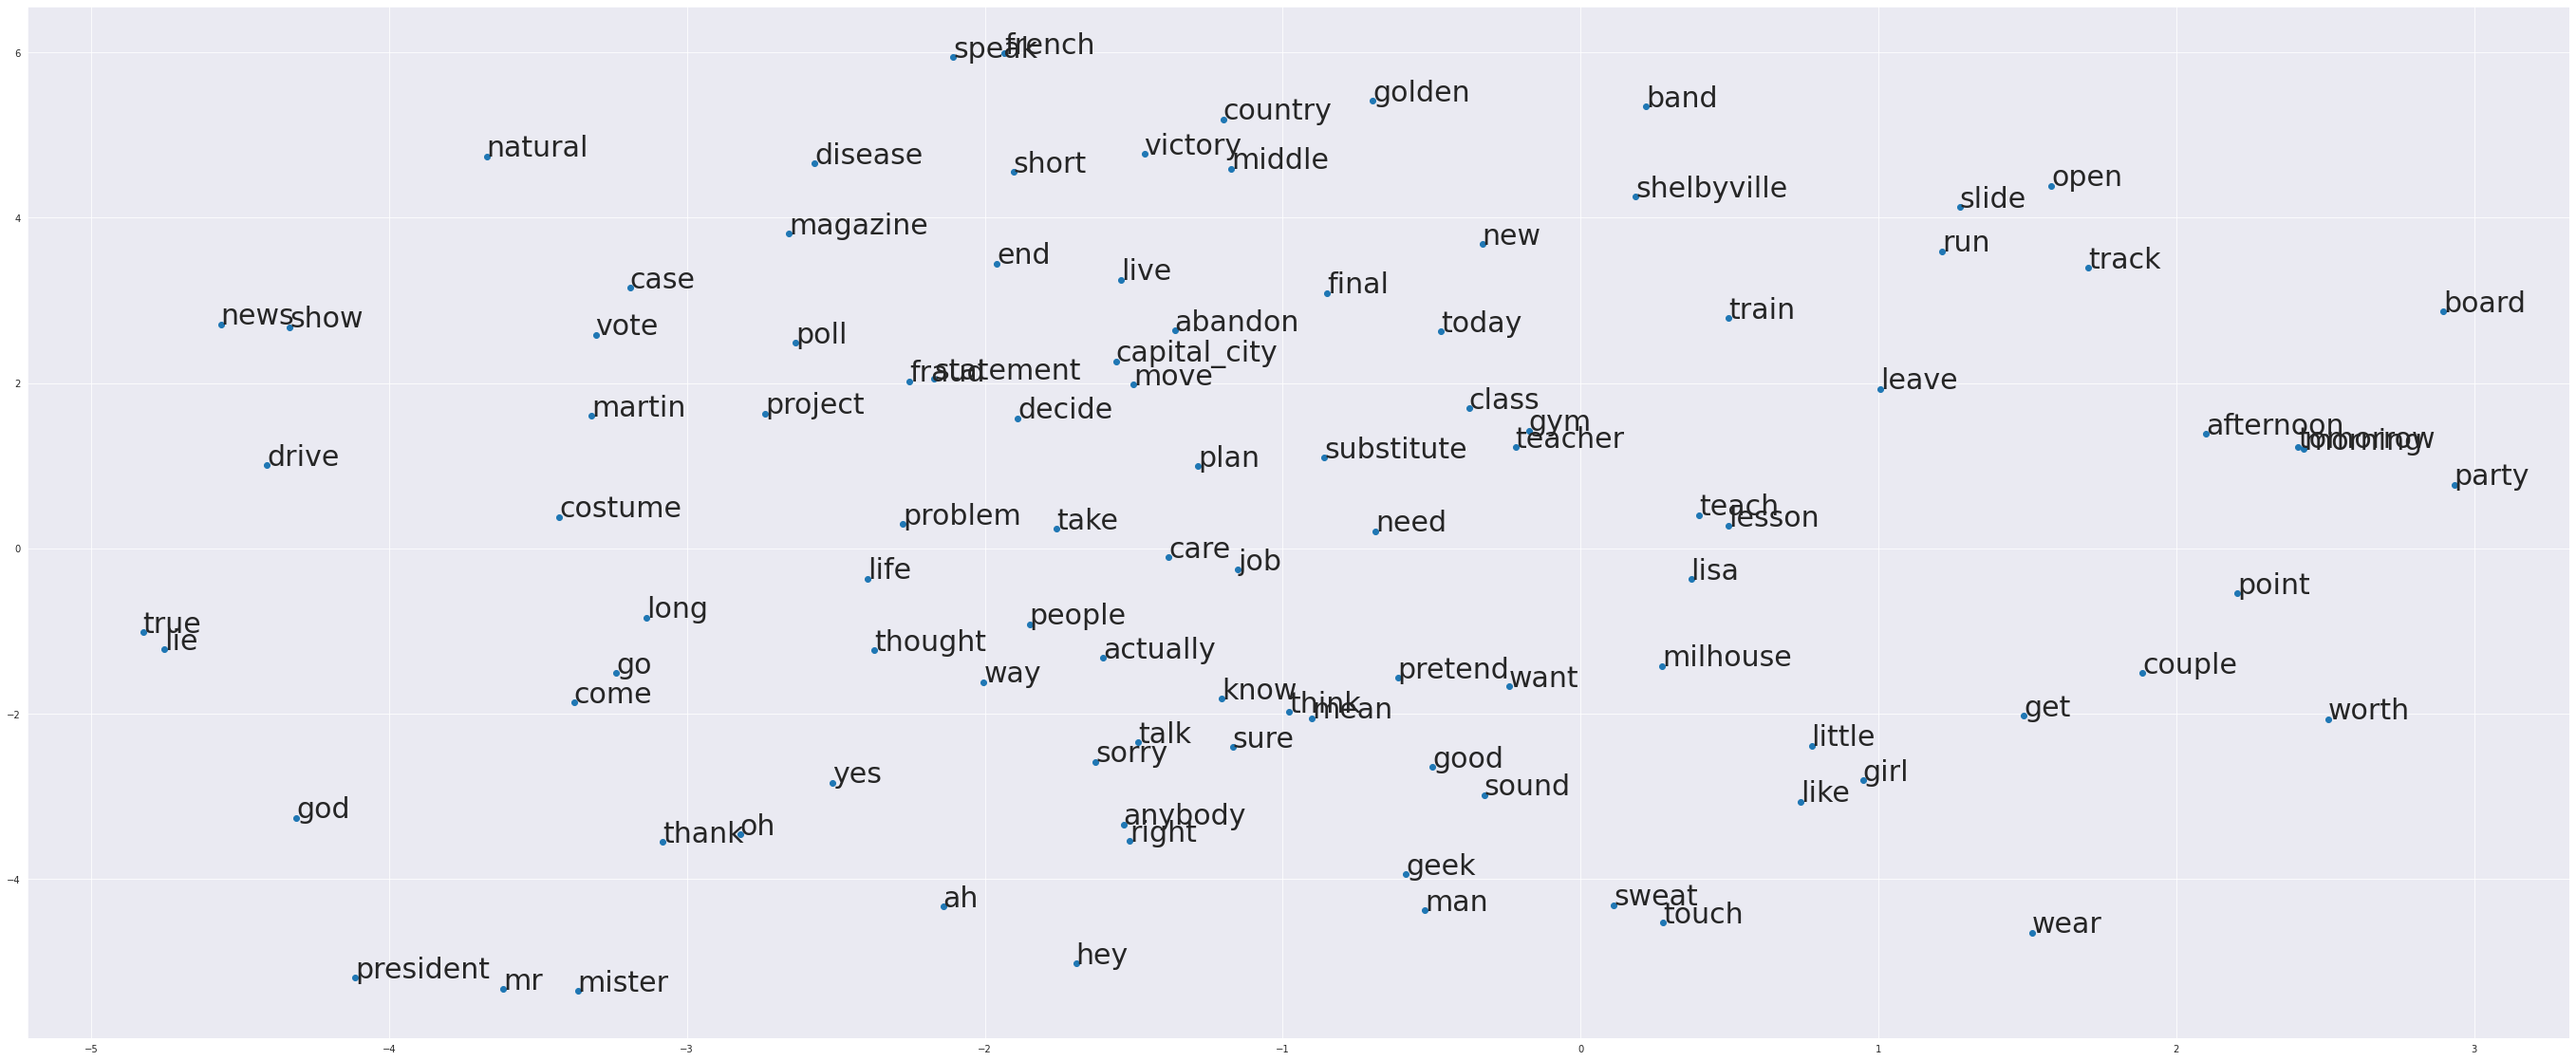

In [ ]:
fig = plt.figure()
fig.set_size_inches(48, 20)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=30)
plt.show()

## Clustering

In [ ]:
from sklearn.cluster import KMeans

# Set "k" (num_clusters) to be 1/5th of the vocabulary size, 
# or an average of 5 words per cluster
word_vectors = w2v_model.wv.syn0
num_clusters = word_vectors.shape[0] // 5

# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans(n_clusters = num_clusters, n_jobs=-2)
idx = kmeans_clustering.fit_predict( word_vectors )
print(idx.shape)

# Create a Word / Index dictionary, 
# mapping each vocabulary word to a cluster number                                                                                            
word_centroid_map = dict(zip(w2v_model.wv.index2word, idx))

# For the first 10 clusters
for cluster in range(0, 10):

    # Print the cluster number  
    print("\nCluster %d" % cluster)

    # Find all of the words for that cluster number, and print them out
    words = []
    for i in range(0, len(word_centroid_map.values())):
        if( list(word_centroid_map.values())[i] == cluster ):
            words.append(list(word_centroid_map.keys())[i])
    print(words)

(3319,)

Cluster 0
['head', 'ground', 'toe', 'tail', 'shoulder', 'tiger', 'puke', 'mud', 'string', 'lamp', 'barrel', 'helmet', 'heel']

Cluster 1
['form', 'program', 'include', 'discover', 'pride', 'slash', 'county', 'application', 'launch', 'pageant', 'violate']

Cluster 2
['take', 'toy', 'carry', 'stamp', 'nurse', 'slave', 'ton', 'worthless', 'smoking', 'priceless', 'repair']

Cluster 3
['yes', 'sir', 'yes_yes']

Cluster 4
['someplace', 'sober']

Cluster 5
['suppose', 'hmmm', 'notice', 'interesting', 'satan', 'field_trip', 'describe', 'frankly', 'ill', 'argue', 'fashion', 'classy', 'sexual', 'technically', 'guilt', 'hearing', 'appointment', 'dictionary', 'attract', 'ease', 'patent', 'entry', 'hammock']

Cluster 6
['fill', 'middle', 'heat', 'sub', 'novelty', 'needle', 'drain', 'stake', 'chemical', 'russian']

Cluster 7
['pit', 'sushi']

Cluster 8
['assistant']

Cluster 9
['original', 'devil', 'james', 'jerry', 'pronounce', 'ben', 'quote', 'lewis', 'joint', 'versus', 'speaker', 'invent

[2031.7269, 1840.2869764983413, 1745.7032805711954, 1694.1865768431817, 1658.5142382161337, 1629.0947184466543, 1601.9898774572741, 1578.675130237959, 1559.4818730461027]


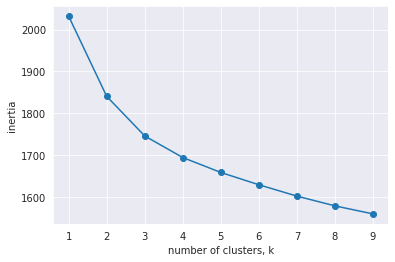

In [ ]:
# inertias: 각 데이터로부터 자신이 속한 군집의 중심까지의 거리

ks = range(1,10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(word_vectors)
    inertias.append(model.inertia_)
print(inertias)


# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [ ]:
from gensim.models import KeyedVectors

w2v_model.wv.save_word2vec_format('w2v_model')

INFO - 05:56:48: storing 3319x300 projection weights into w2v_model


In [ ]:
!python -m gensim.scripts.word2vec2tensor --input w2v_model --output w2v_model

2021-01-21 05:56:50,750 - word2vec2tensor - INFO - running /usr/local/lib/python3.6/dist-packages/gensim/scripts/word2vec2tensor.py --input w2v_model --output w2v_model
2021-01-21 05:56:50,750 - utils_any2vec - INFO - loading projection weights from w2v_model
2021-01-21 05:56:51,774 - utils_any2vec - INFO - loaded (3319, 300) matrix from w2v_model
2021-01-21 05:56:52,671 - word2vec2tensor - INFO - 2D tensor file saved to w2v_model_tensor.tsv
2021-01-21 05:56:52,672 - word2vec2tensor - INFO - Tensor metadata file saved to w2v_model_metadata.tsv
2021-01-21 05:56:52,673 - word2vec2tensor - INFO - finished running word2vec2tensor.py


## Keras로 Negative Sampling 구현하기

In [148]:
df_clean.head()

,clean
0,actually little disease magazine news show nat...
2,know sure like talk touch lesson plan teach
3,life worth live
4,poll open end recess case decide thought final...
7,victory party slide


In [152]:
tokenized_doc = df_clean['clean'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.to_list()

In [153]:
# 단어가 1개 이하인 샘플의 인덱스 찾아 제거
drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) <= 1]
tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)
print('총 샘플 수 :',len(tokenized_doc))

총 샘플 수 : 85964


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [154]:
# 정수 인코딩

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
idx2word = {v:k for k, v in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

In [155]:
vocab_size = len(word2idx) + 1 
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 30066


In [156]:
from tensorflow.keras.preprocessing.sequence import skipgrams

skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded]

pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(5):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          idx2word[pairs[i][0]], pairs[i][0], 
          idx2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(disease (1541), hoooour (20440)) -> 0
(magazine (710), think (8)) -> 1
(natural (1079), zeppelin (5553)) -> 0
(little (21), photon (23697)) -> 0
(magazine (710), show (403)) -> 1


In [157]:
print('전체 샘플 수 :',len(skip_grams))

전체 샘플 수 : 85964


In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

embed_size = 100

# 중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1, ), dtype='int32')
word_embedding = Embedding(vocab_size, embed_size)(w_inputs)

# 주변 단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype='int32')
context_embedding  = Embedding(vocab_size, embed_size)(c_inputs)

dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')
plot_model(model, to_file='kreas_word2vec_model.png', show_shapes=True, show_layer_names=True)

for epoch in range(1, 6):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X,Y)  
    print('Epoch :',epoch, 'Loss :',loss)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       3006600     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       3006600     input_2[0][0]                    
______________________________________________________________________________________________